# Generating and Segmenting with Character-Level Transformer

In [1]:
import hashlib
import os
import yaml
import scipy.stats
import pandas as pd
import numpy as np
import sys
from multiprocessing import Pool
from IPython.display import clear_output

import torch
from src.model.model import next_char_transformer

In [2]:
#run_dir = 'wandb/run-20221110_041703-6926109/files' # old model, aligned
run_dir = 'wandb/run-20221203_063741-9317928/files' # new model
# run_dir = 'wandb/run-20221216_170649-829928499/files' # number model

seed = 32

checkpoint_path = run_dir + '/best.pt'
with open(run_dir + '/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Load corpus

In [3]:
data_dir = config['root_path']['value']
fn = 'corpus.{}.data'.format('.'.join(data_dir.split('/')))
if os.path.exists(fn):
    print('Loading cached dataset...')
    corpus = torch.load(fn)
    ntokens = len(corpus.dictionary)
else:
    print('No precached dataset found')
    raise Exception('No precached dataset found')
print (corpus.dictionary.word2idx)

Loading cached dataset...
{'<PAD>': 0, '<BOUNDARY>': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '10': 9, '11': 10, '12': 11, '13': 12, '14': 13, '15': 14, '16': 15, '17': 16, '18': 17, '19': 18, '20': 19, '21': 20, '22': 21, '23': 22, '24': 23, '25': 24, '26': 25, '27': 26, '28': 27, '29': 28, '30': 29, '31': 30, '32': 31, '33': 32, '34': 33, '35': 34, '36': 35, '37': 36, '38': 37, '39': 38, '40': 39, '41': 40, '42': 41, '43': 42, '44': 43, '45': 44, '46': 45, '47': 46, '48': 47, '49': 48, '50': 49, '51': 50, '52': 51, '53': 52, '54': 53, '55': 54, '56': 55, '57': 56, '58': 57, '59': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '70': 69, '71': 70, '72': 71, '73': 72, '74': 73, '75': 74, '76': 75, '77': 76, '78': 77, '79': 78, '80': 79, '81': 80, '82': 81, '83': 82, '84': 83, '85': 84, '86': 85, '87': 86, '88': 87, '89': 88, '90': 89, '91': 90, '92': 91, '93': 92, '94': 93, '95': 94, '96': 95, '97': 96, '98': 97,

## Load model

In [4]:
# Set the random seed manually for reproducibility.
torch.manual_seed(seed)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Loading on device: {device}')

Loading on device: cpu


In [5]:
with open(checkpoint_path, 'rb') as f:
    checkpoint = torch.load(f, map_location=device)
model = next_char_transformer(ntokens,
                                n_layers=config['n_layers']['value'],
                                hidden_size=config['hidden_size']['value'],
                                inner_linear=config['inner_linear']['value'],
                                max_sequence_len=config['sequence_length']['value']).to(device)
model.load_state_dict(checkpoint['learner_state_dict'], strict=False)
model.eval()

NextCharTransformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=64, out_features=64, bias=True)
            (1): Linear(in_features=64, out_features=64, bias=True)
            (2): Linear(in_features=64, out_features=64, bias=True)
            (3): Linear(in_features=64, out_features=64, bias=True)
          )
          (dropout): Dropout(p=0.55, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=64, out_features=128, bias=True)
          (w_2): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.55, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.55, inplace=False)
          )
          (1): SublayerConnec

In [6]:
from src.data.data import subsequent_mask

def generate_with_padding(prompt, temperature=1):
    """ Does greedy generation and incorporates padding in inputted sequence. 
    
    Generates until the end token <END> is reached, or max sequence length reached. """

    seq_len = config['sequence_length']['value']
    masks = subsequent_mask(seq_len)
    sentence = list(prompt)
    sentence_ids = [[corpus.dictionary.word2idx[t]] for t in sentence]
    padding = [[corpus.dictionary.word2idx['<PAD>']]]*(seq_len-len(sentence))

    # Input to model is always length seq_len
    input = torch.tensor(sentence_ids + padding, dtype=torch.long, device=device)

    with torch.no_grad():
        word_idx = 1
        i = len(sentence)-1
        while word_idx != 2 and i < seq_len:
            mask = masks[0][i]
            output = model(input, mask)[-1]
            last_token = output[i][i]
            word_weights = last_token.squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            word_tensor = torch.Tensor([[word_idx]]).long().to(device)
            input = torch.cat([input[:i+1], word_tensor, input[i+2:]],0)
            sentence.append(corpus.dictionary.idx2word[word_idx])
            i+=1
            print (''.join(sentence))
            
    return sentence
    
# def generate(prompt, temperature=1):
    # """ Does greedy generation. 
    
    # Generates until max sequence length reached. """

    # seq_len = config['sequence_length']['value']
    # sentence = list(prompt)
    # sentence_ids = [[corpus.dictionary.word2idx[t]] for t in sentence]

    # # Input to model is always length seq_len
    # input = torch.tensor(sentence_ids, dtype=torch.long, device=device)

    # with torch.no_grad():
    #     word_idx = 1
    #     i = len(sentence)-1
    #     while word_idx != 2 and i < seq_len:
    #         masks = subsequent_mask(input.size(0))
    #         mask = masks[0][-1]
    #         output = model(input, mask)[-1]
    #         last_token = output[i][i]
    #         word_weights = last_token.squeeze().div(temperature).exp().cpu()
    #         word_idx = torch.multinomial(word_weights, 1)[0]
    #         word_tensor = torch.Tensor([[word_idx]]).long().to(device)
    #         input = torch.cat([input, word_tensor],0)
    #         sentence.append(corpus.dictionary.idx2word[word_idx])
    #         i+=1
    #         print (''.join(sentence))
            
    # return sentence
    
def generate(prompt, temperature=1):
    """ Does greedy generation. 
    
    Generates until max sequence length reached. """

    seq_len = config['sequence_length']['value']
    sentence = list(prompt)
    sentence_ids = [corpus.dictionary.word2idx[t] for t in sentence]

    # Input to model is always length seq_len
    input = torch.LongTensor([sentence_ids], device=device)

    with torch.no_grad():
        word_idx = 1
        i = len(sentence)-1
        while word_idx != 2 and i < seq_len:
            mask = torch.ones(1, 1, input.size(1))
            output = model(input, mask)[-1]
            last_token = output[0][i]
            word_weights = last_token.squeeze().div(temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            word_tensor = torch.Tensor([[word_idx]]).long().to(device)
            input = torch.cat([input, word_tensor],1)
            sentence.append(corpus.dictionary.idx2word[word_idx])
            i+=1
            print (''.join(sentence))
            
    return sentence


In [7]:
prompt = ['<BOUNDARY>', '24', '25']
#prompt = "anarchism originated as a term of abuse first used against early working class rad"
# prompt = ['<BOUNDARY>', 'l', 'ʊ', 'k']
#prompt = ['<START>', 'j', 'uː']

sentence = generate(prompt, 1)

<BOUNDARY>242526
<BOUNDARY>24252627
<BOUNDARY>2425262728
<BOUNDARY>242526272829
<BOUNDARY>24252627282930
<BOUNDARY>2425262728293031
<BOUNDARY>242526272829303132
<BOUNDARY>24252627282930313233
<BOUNDARY>2425262728293031323334
<BOUNDARY>242526272829303132333435
<BOUNDARY>24252627282930313233343536
<BOUNDARY>2425262728293031323334353637
<BOUNDARY>242526272829303132333435363738
<BOUNDARY>24252627282930313233343536373839


## Attention Visualisation

In [8]:
import matplotlib.pyplot as plt
import seaborn

Encoder Layer 2


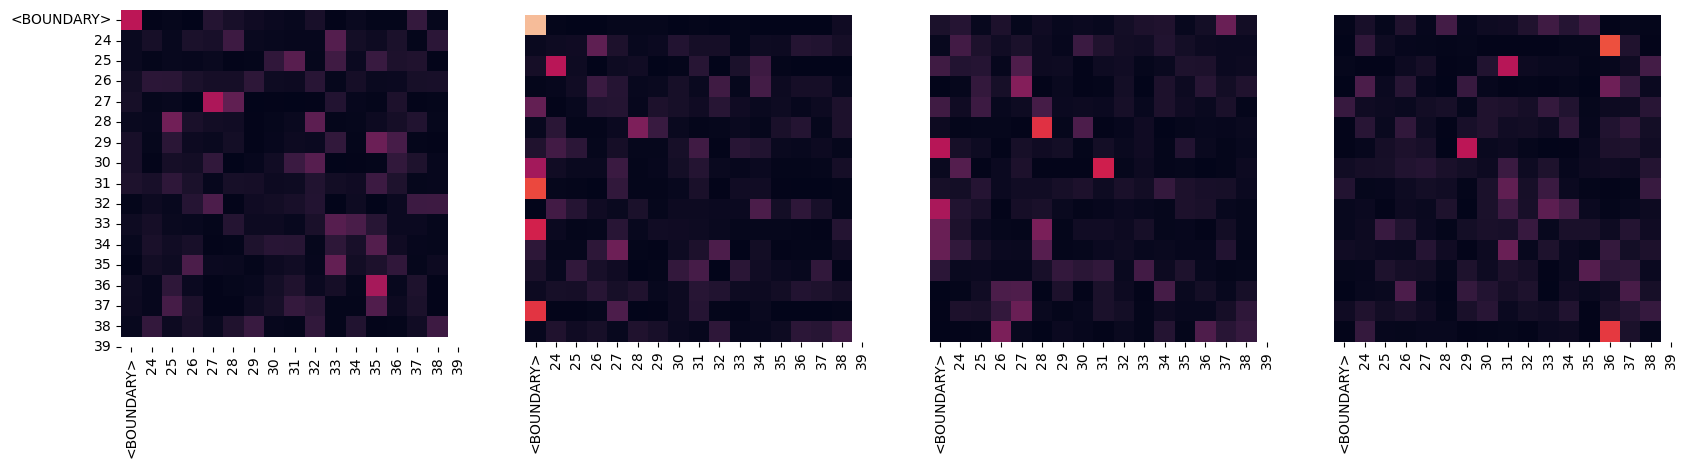

Encoder Layer 4


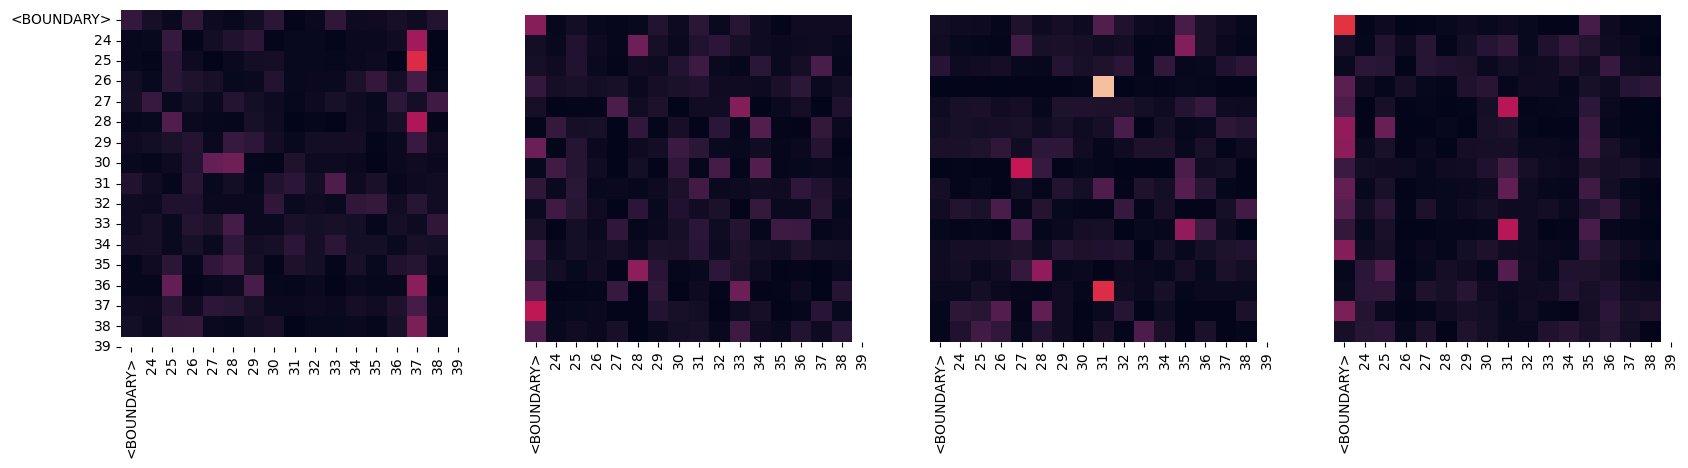

In [9]:
prompt = sentence
#TODO: Should pass in a square mask

def visualise_attention():   
    for layer in range(1, model.n_layers, 2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print("Encoder Layer", layer+1)
        for h in range(4):
            seaborn.heatmap(model.encoder.layers[layer].self_attn.attn[0, h].data, 
                        xticklabels=prompt, square=True, yticklabels=prompt if h ==0 else [], vmin=0, vmax=1,
                        cbar=False, ax=axs[h])
        plt.show()
visualise_attention()


## Prediction Error

Plotting of prediction error from a model given a prompt.

In [10]:
def plot_utterance(data, measures, cutoffs=None):
    """ Plots a single utterance against each measure in `data` to visualise segmentation. 
    Parameters
    ----------
    data : dict
        A processed utterance containing statistical and boundary information. See `process_utterance` method above.
    measures : sequence of str
        List of keys in `data` to plot.
    cutoffs : sequence of str, optional
        Cutoff values used for segmentation, plotted as horizontal lines on each plot.
    """
    _, axs = plt.subplots(len(measures),1, figsize=(20, 10))
    for i, ax in enumerate(axs):
        ax.plot('Pos', measures[i], data=data)
        ax.set_ylabel(measures[i])
        ax.set_xticks(data.Pos, data.Phoneme)
        for j, start in enumerate(data.Starts):
            if start:
                ax.axvline(x=j, color='grey', alpha=0.5)
        if cutoffs:
            ax.axhline(y=cutoffs[i], color='pink', alpha=0.5)
    ax.set_xlabel('Phonemes')
    plt.show()

def print_best_result(results, score):
    best_results = results[results[score] == results[score].max()].iloc[0]
    best_result = float(best_results[score])
    best_cutoff = float(best_results['Cutoff'])
    print('Best cutoff:',best_cutoff)
    print('Best {} at cutoff {}: {}'.format(score, best_cutoff, round(best_result*100, 2)))

def plot_scores_by_cutoff(results):
    """ Plot each measure against the different cutoffs used. Adds a vertical and horizontal line at the best value for each score. """
    num_columns = 3
    scores = sorted(list(set(results.keys()) - {'Cutoff'}))
    num_rows = len(results.keys()) // num_columns
    _, axs = plt.subplots(num_rows, num_columns, figsize=(20, 20))
    column = 0
    for i, score in enumerate(scores):
        graph = seaborn.lineplot(results, x='Cutoff', y=score, ax=axs[i//num_columns, column])
        max_score = results[results[score] == results[score].max()].head(1)
        max_cutoff = float(max_score['Cutoff'])
        max_score = float(max_score[score])
        graph.axvline(max_cutoff, color='grey', alpha=0.5)
        graph.axhline(max_score, color='pink', alpha=0.5)
        graph.set_ybound(0,1)
        column = (column + 1) % num_columns
    plt.show()

def plot_roc(results, measure1, measure2):
    """ Plot two scores against each other (e.g. precision against recall) """
    seaborn.lineplot(results, x=measure1, y=measure2)
    plt.show()

In [11]:
from src.segmentation.segment import Segmenter
#segmenter = Segmenter(model, open('data/Eng-NA/test.txt', 'r').readlines()[:3000], corpus)
segmenter = Segmenter(model, [line for line in open('data/Debug/test.txt', 'r').readlines()[:3000] if len(line.split(' ')) < 16], corpus)

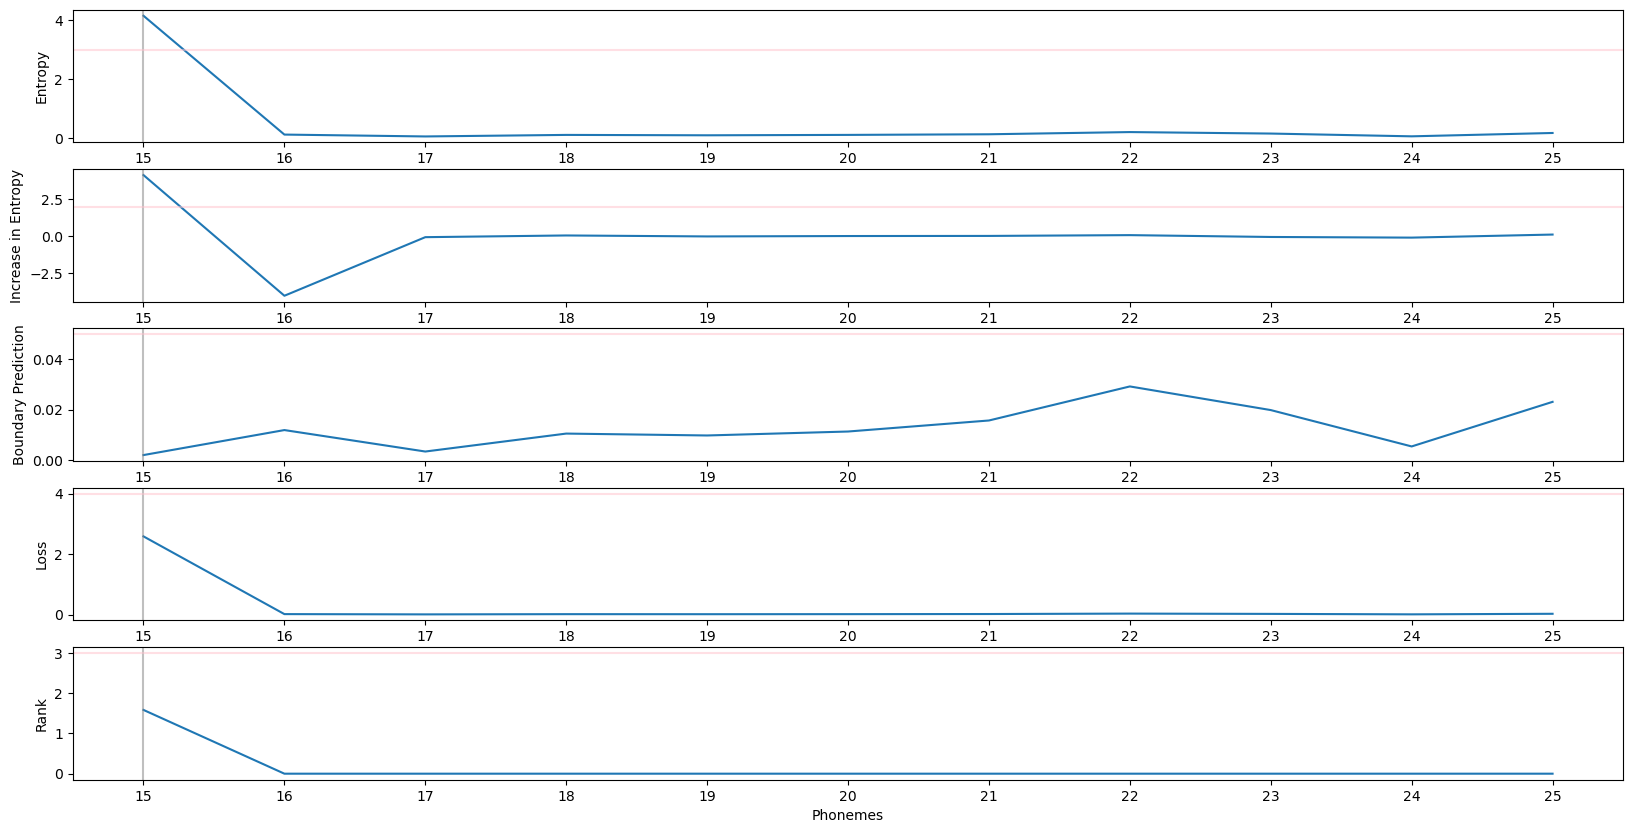

1516171819202122232425


In [12]:
plot_utterance(segmenter.processed_utterances[21], ['Entropy', 'Increase in Entropy', 'Boundary Prediction', 'Loss', 'Rank'], [3, 2, 0.05, 4, 3])
print(''.join(list(segmenter.processed_utterances[21].Phoneme)))

In [13]:
def summarise_segmentation(measure='Entropy', score='type_fscore', cutoffs=np.linspace(0,5,51)):

    cutoff_data = segmenter.evaluate_cutoff_segmentation(measure, cutoffs)
    print_best_result(cutoff_data, 'type_fscore')
    plot_scores_by_cutoff(cutoff_data)
    plot_roc(cutoff_data[:-4], 'type_precision', 'type_recall')

    spike_data = segmenter.evaluate_spike_segmentation(measure)
    print('Spike {}: {}'.format(score, round(spike_data[score]*100,2)))

Best cutoff: 3.3000000000000003
Best type_fscore at cutoff 3.3000000000000003: 31.98


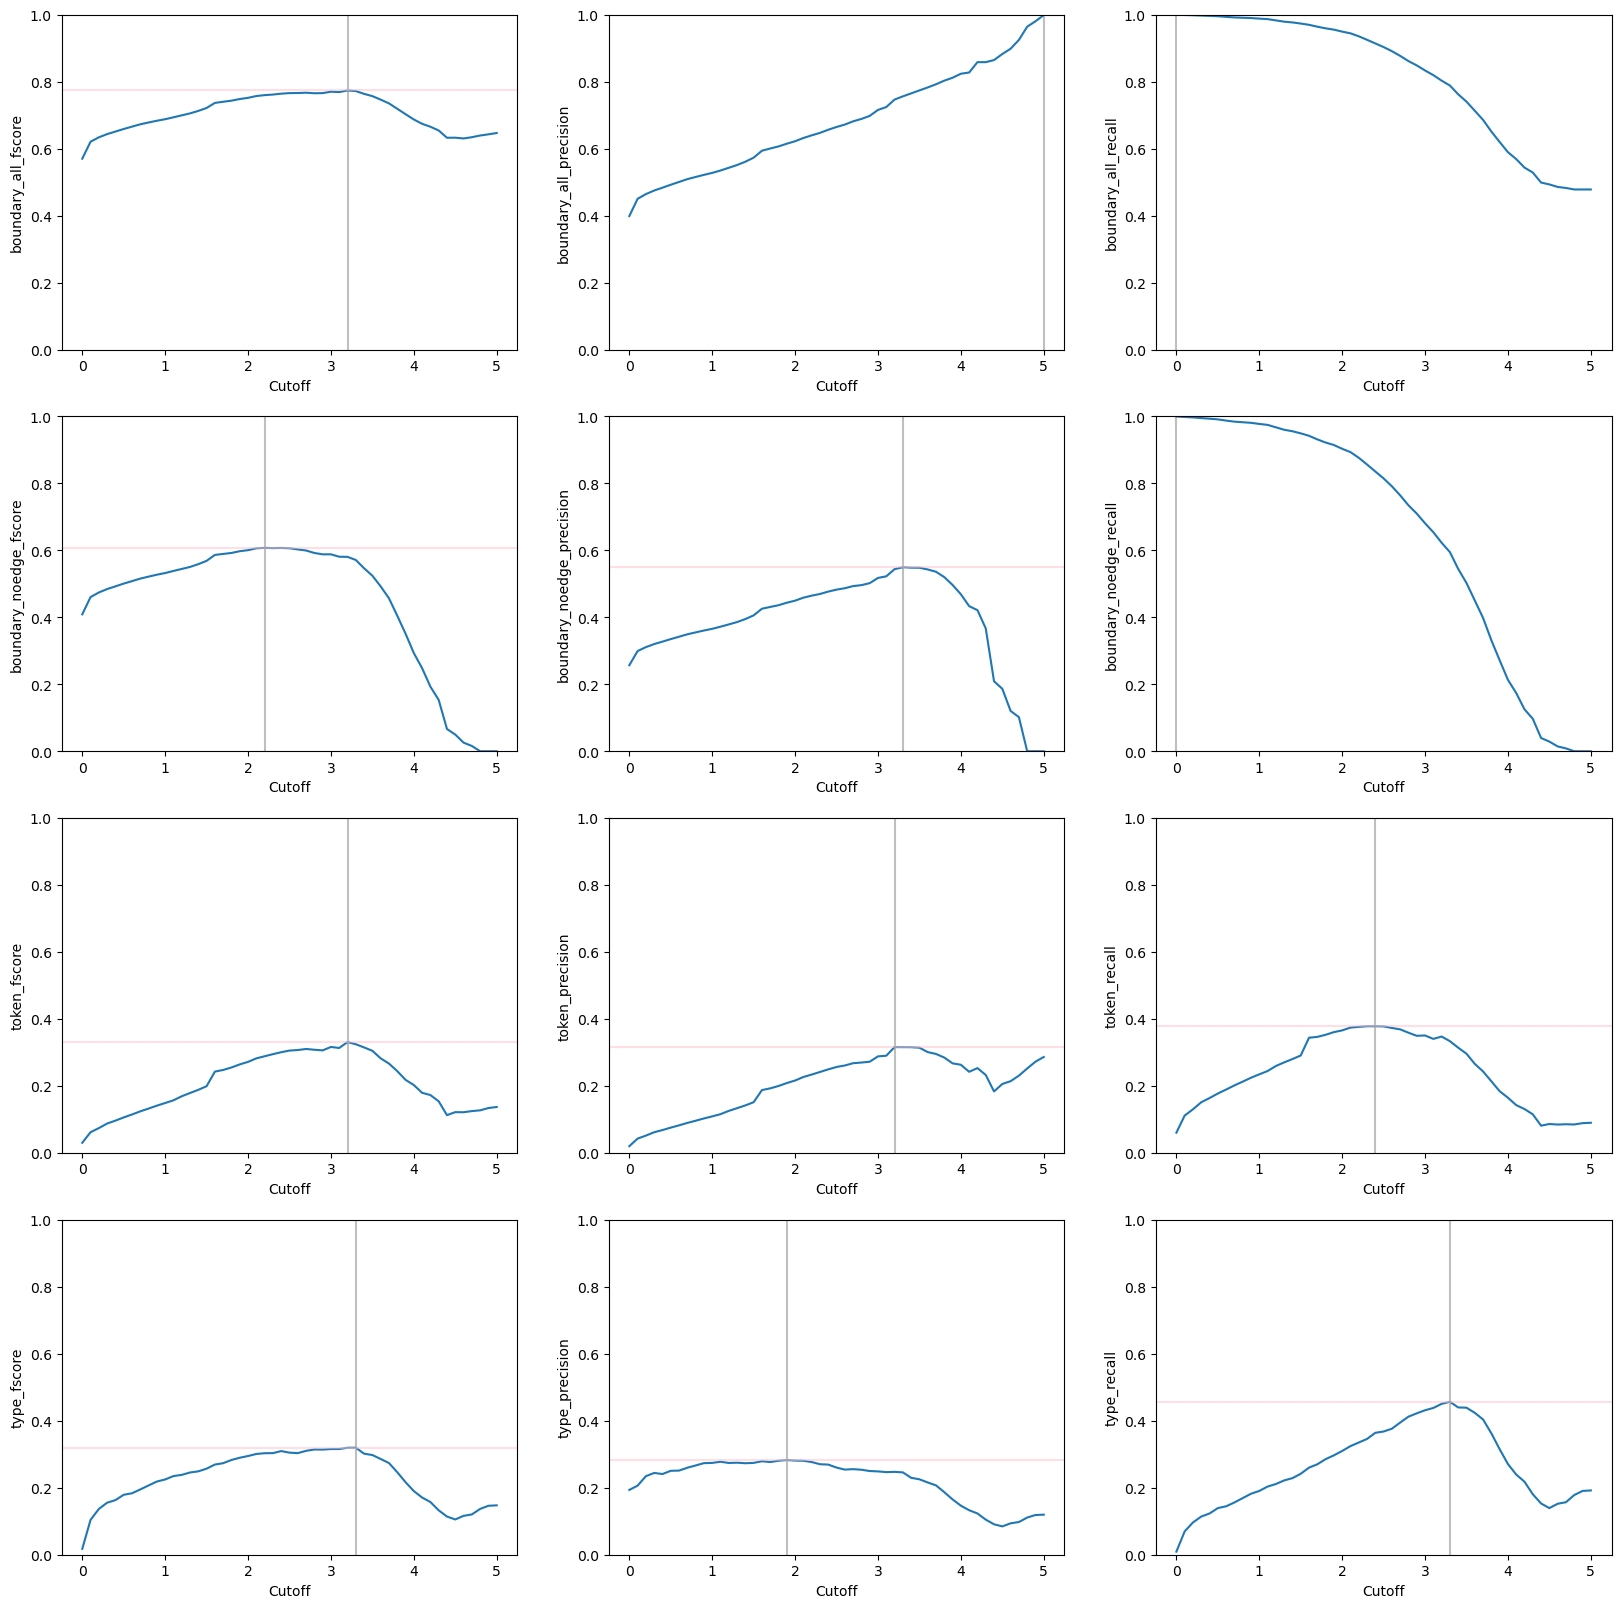

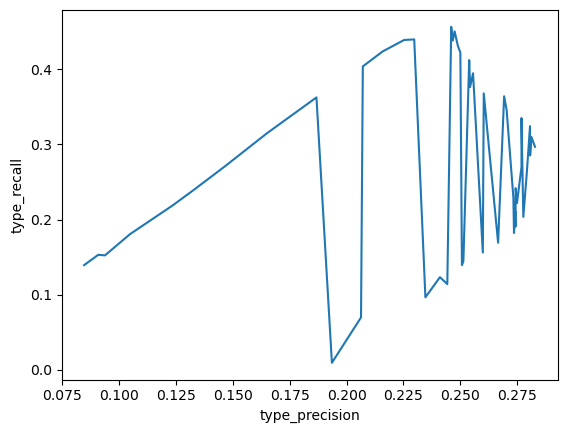

Spike type_fscore: 40.07


In [14]:
summarise_segmentation('Entropy', cutoffs=np.linspace(0,5,51))

Best cutoff: 0.5
Best type_fscore at cutoff 0.5: 43.9


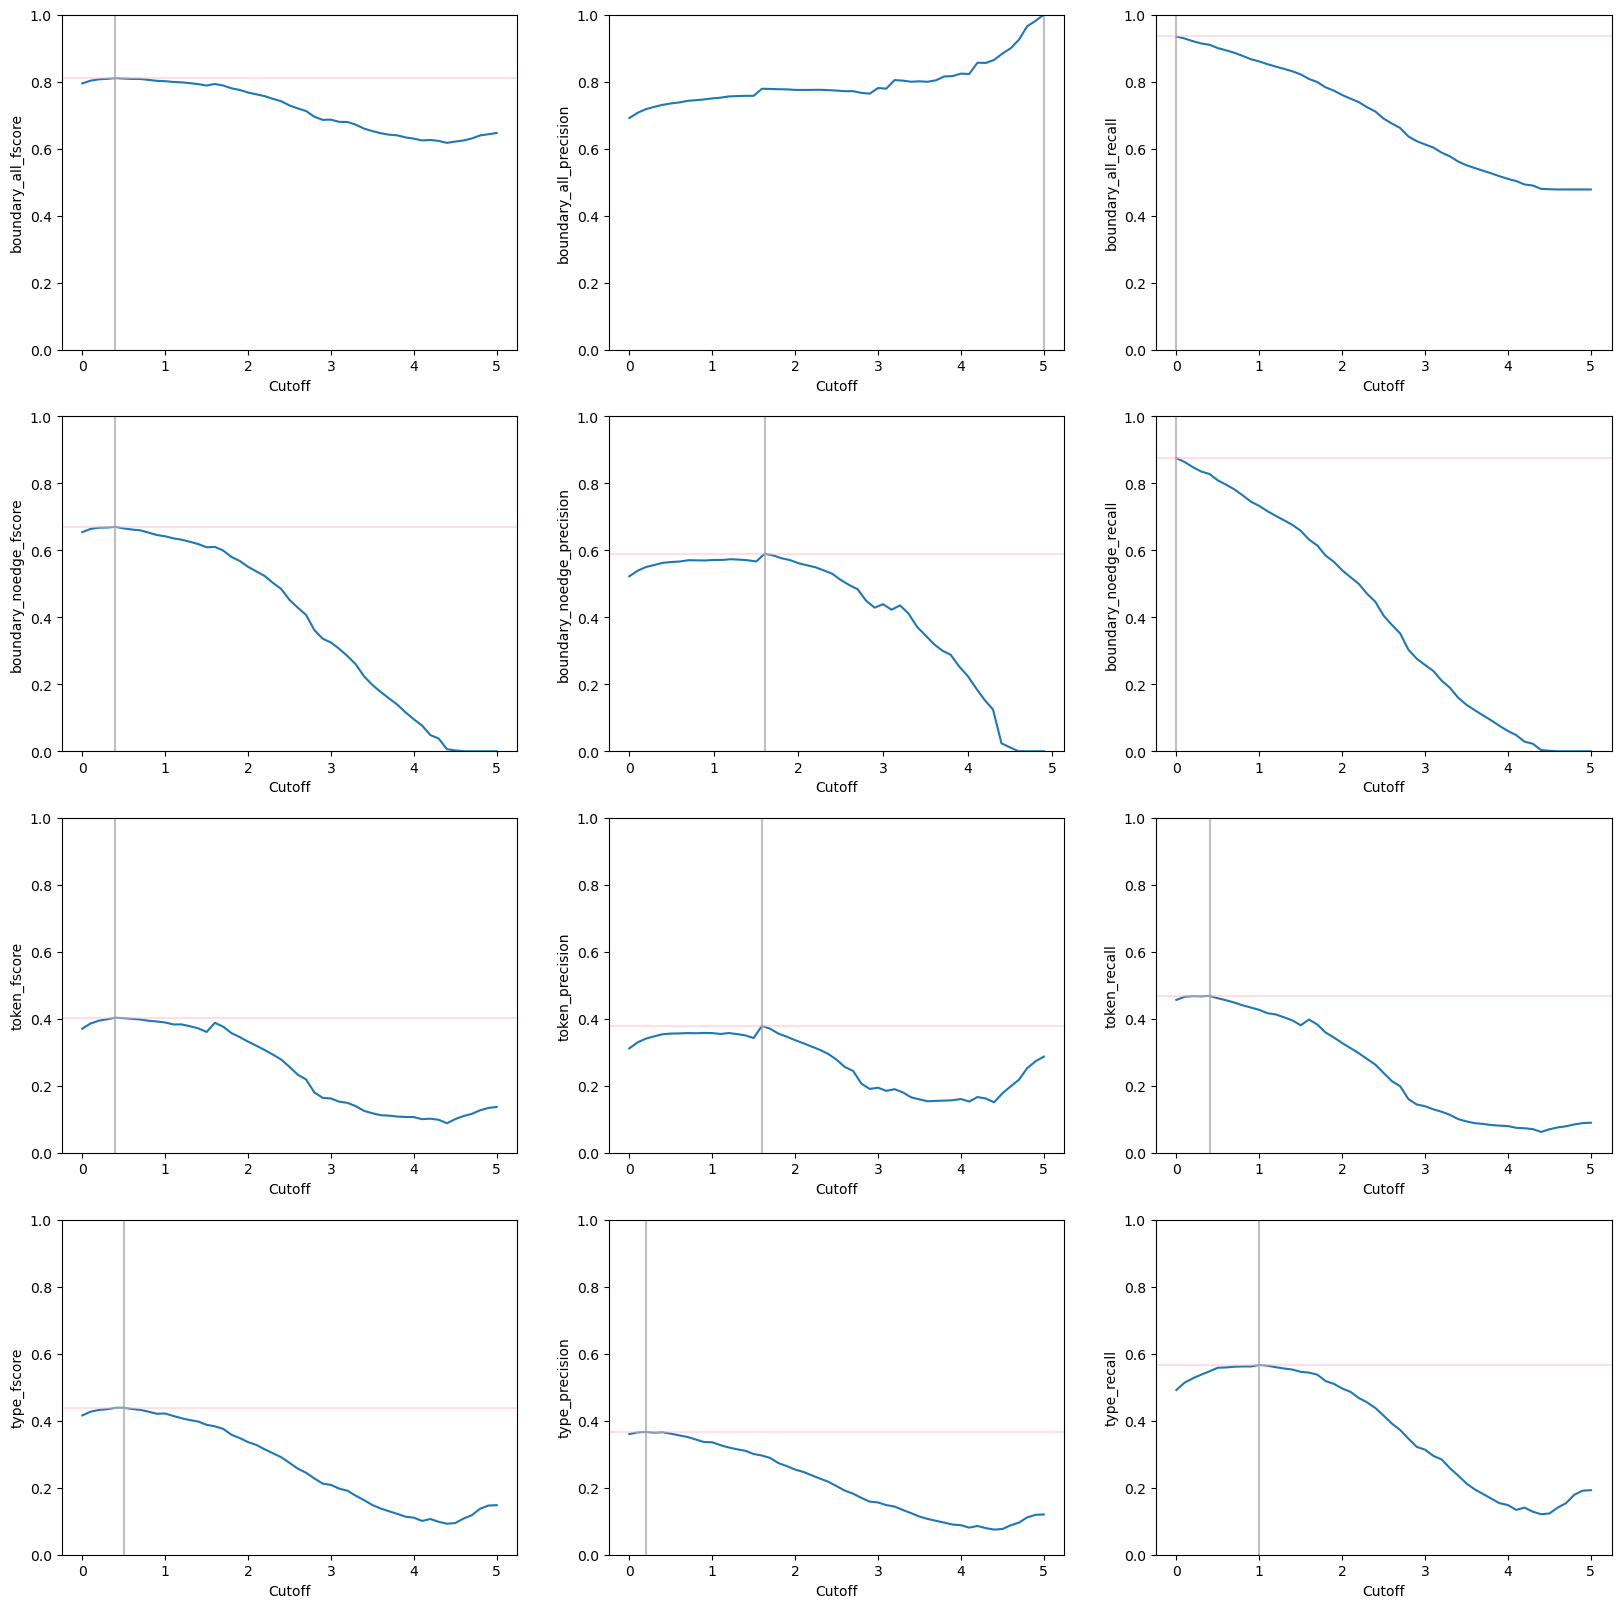

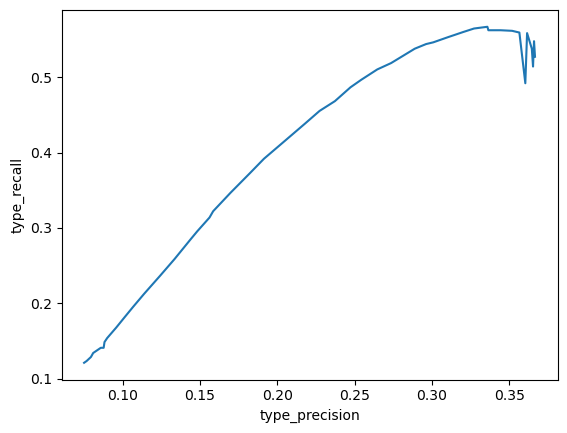

Spike type_fscore: 37.82


In [15]:
summarise_segmentation('Increase in Entropy', cutoffs=np.linspace(0,5,51))

Best cutoff: 3.0
Best type_fscore at cutoff 3.0: 25.49


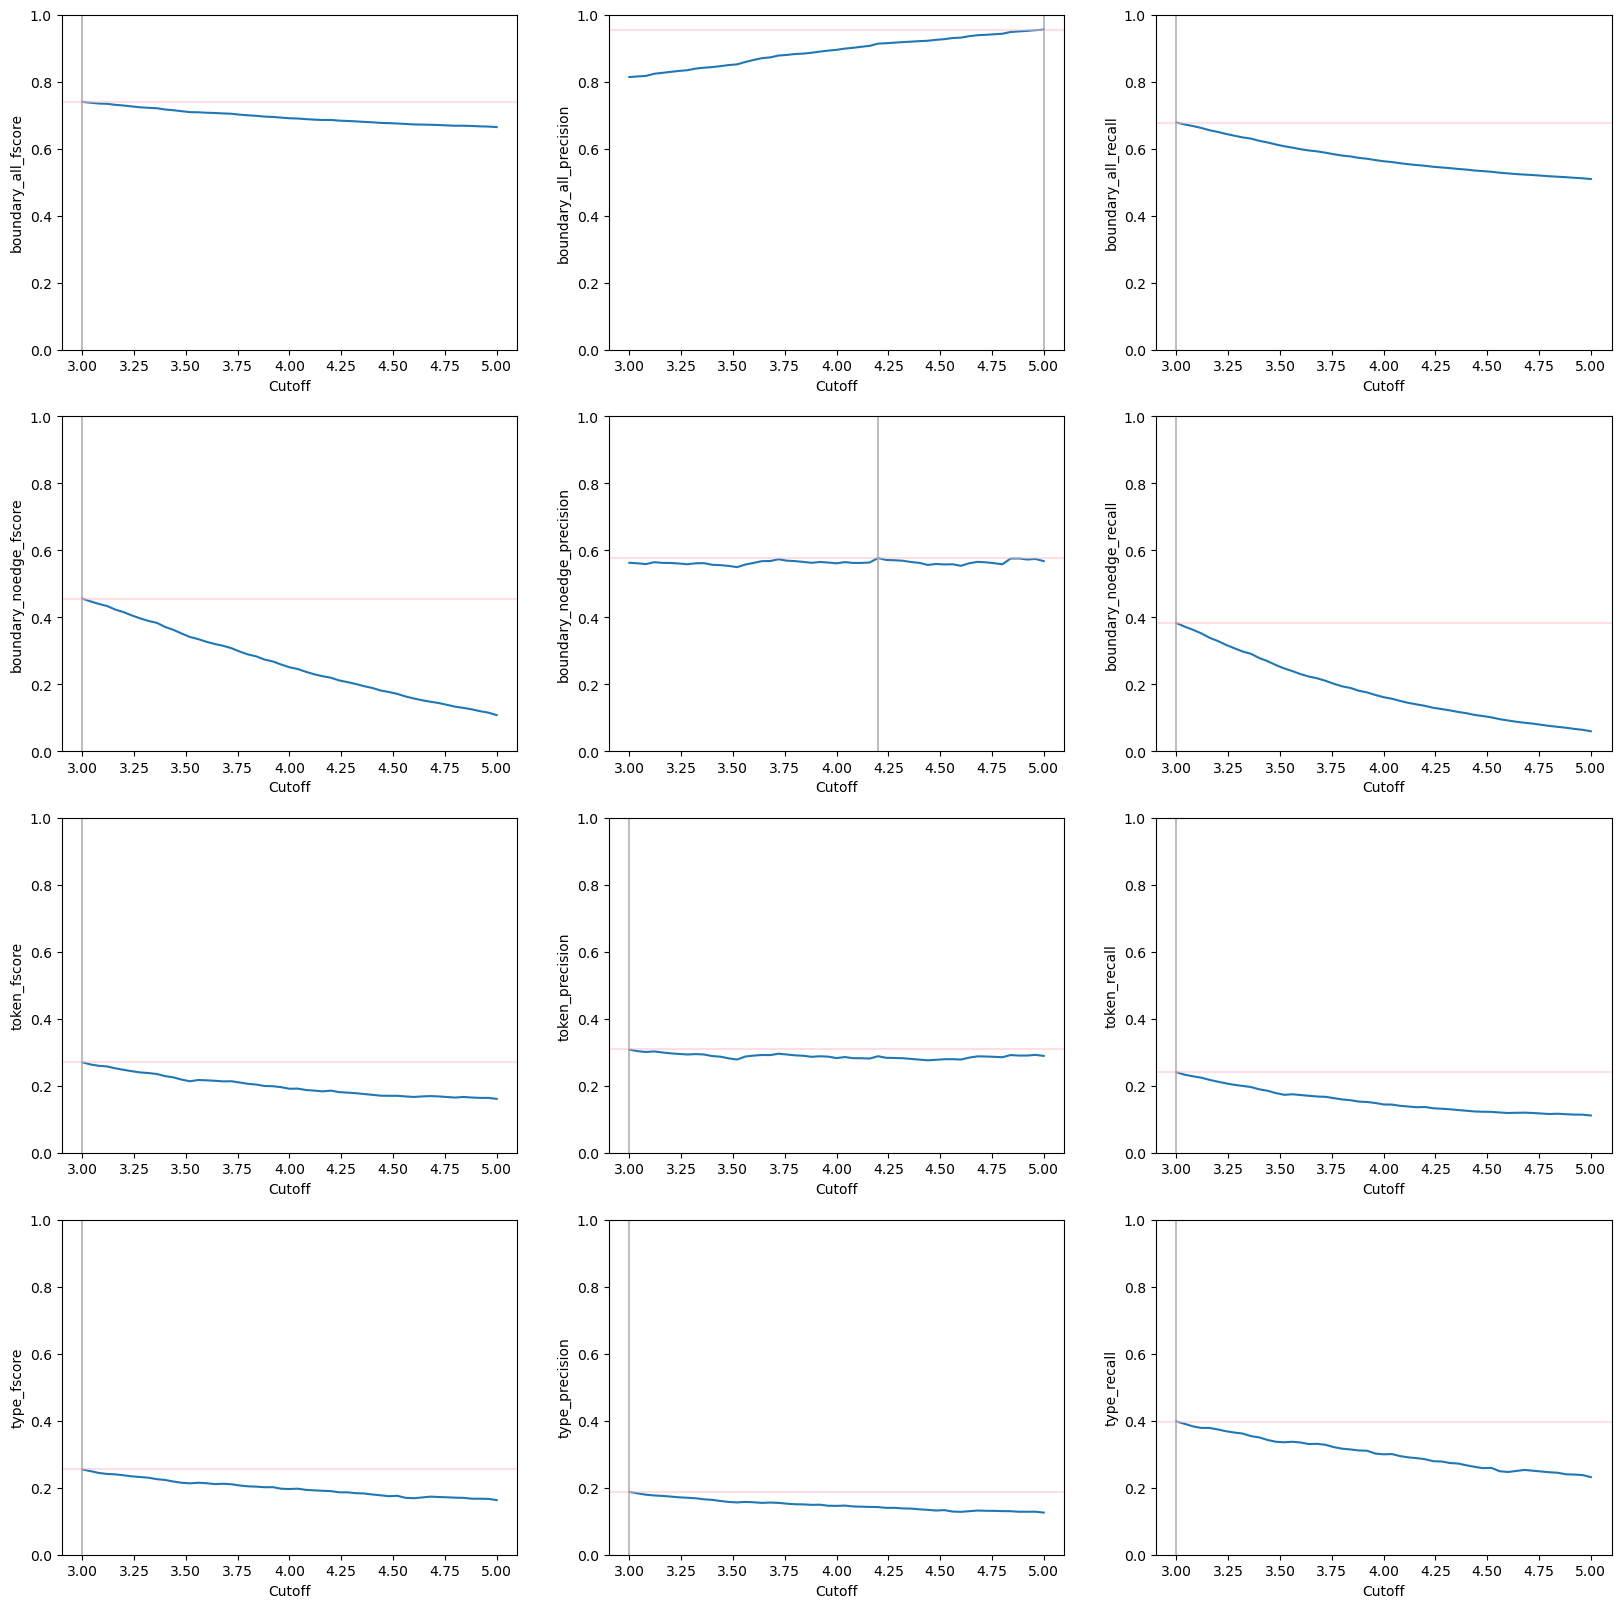

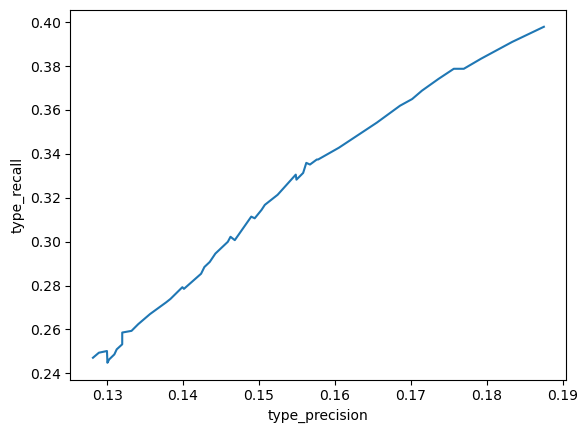

Spike type_fscore: 35.42


In [16]:
summarise_segmentation('Loss', cutoffs=np.linspace(3,5,51))

Best cutoff: 0.6
Best type_fscore at cutoff 0.6: 42.06


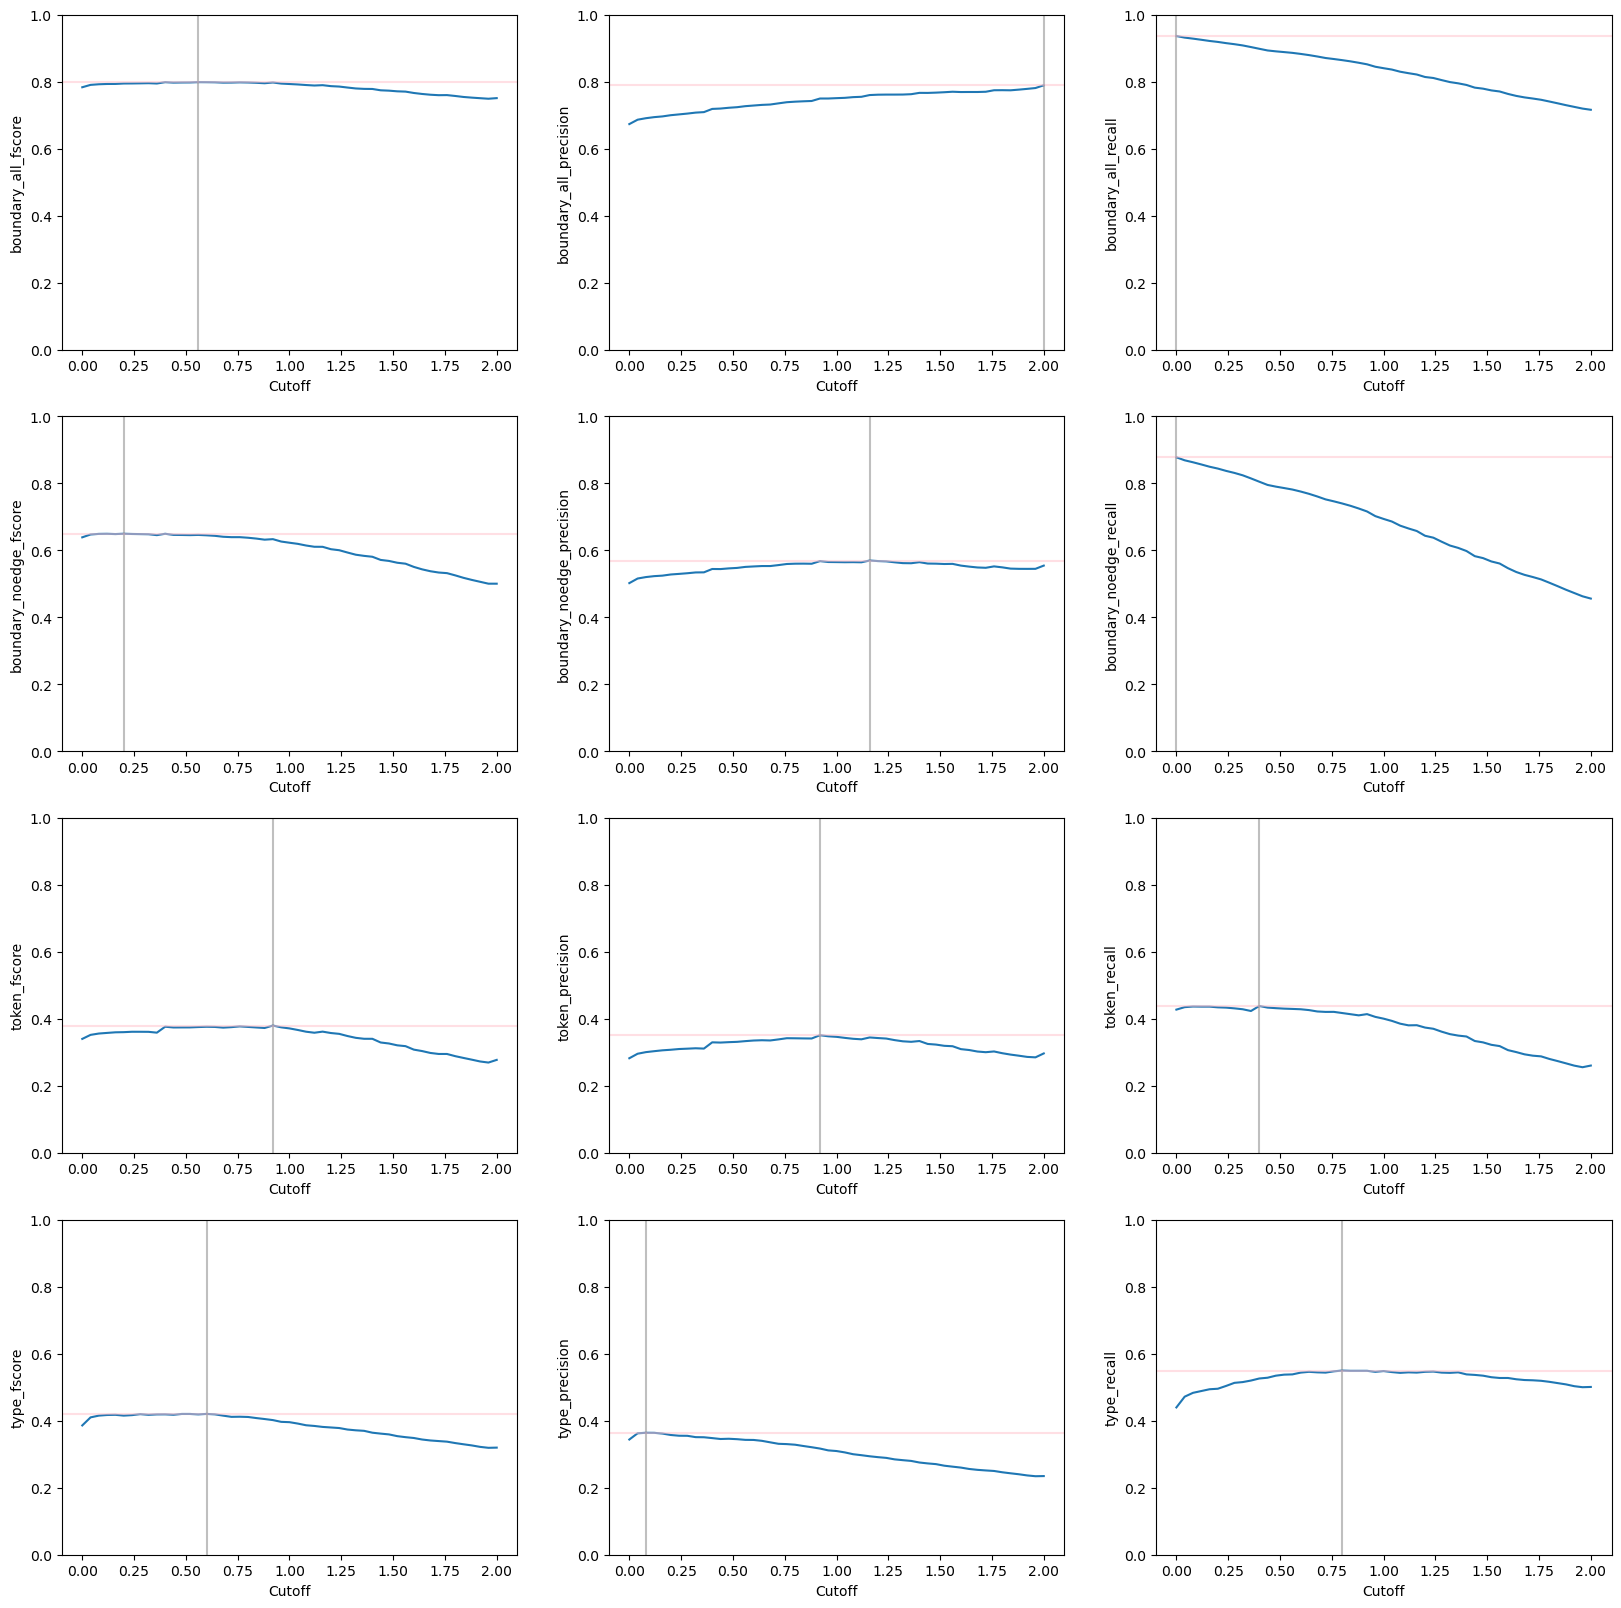

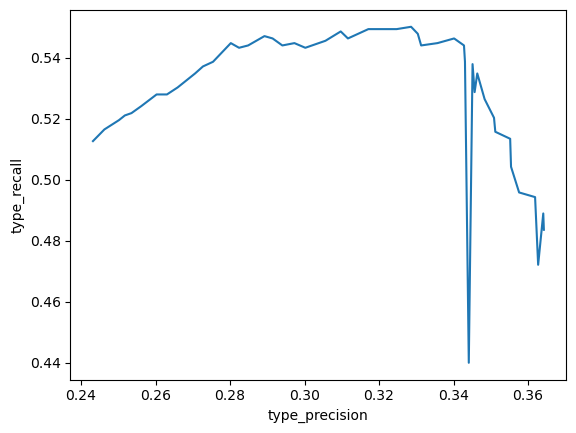

Spike type_fscore: 37.44


In [17]:
summarise_segmentation('Increase in Loss', cutoffs=np.linspace(0,2,51))

Best cutoff: 0.01
Best type_fscore at cutoff 0.01: 41.59


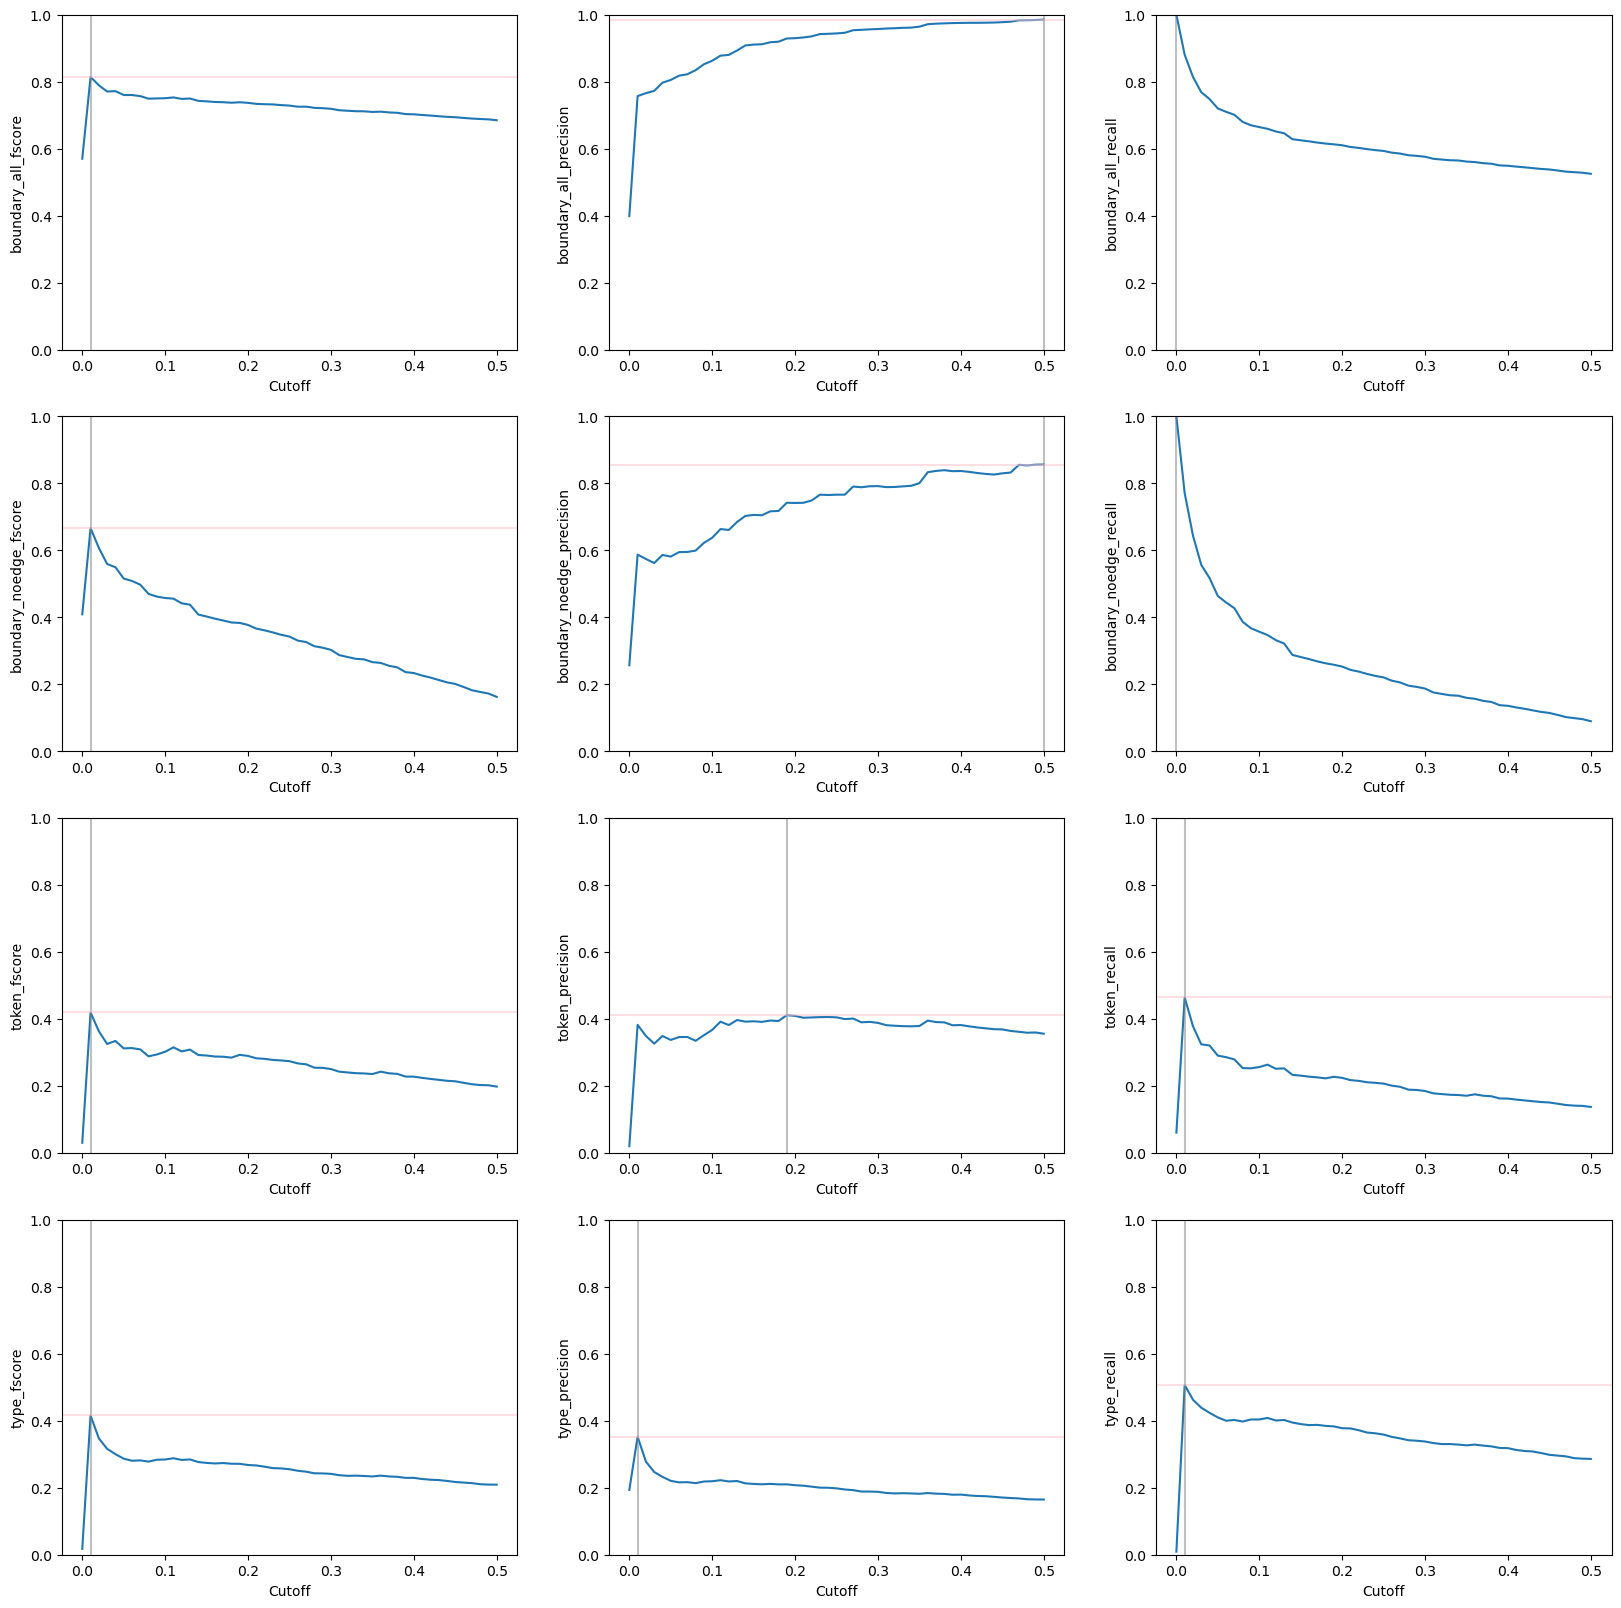

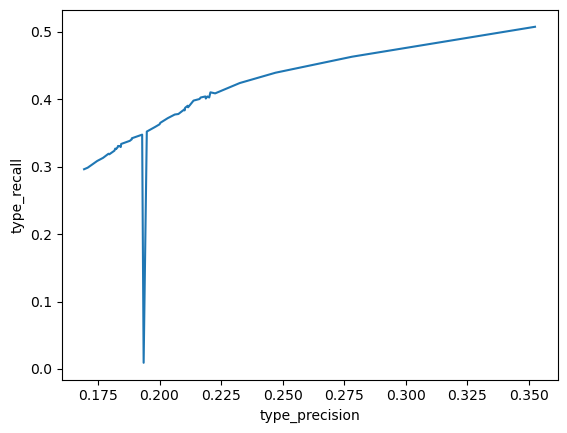

Spike type_fscore: 37.58


In [18]:
summarise_segmentation('Boundary Prediction', cutoffs=np.linspace(0,0.5,51))

Best cutoff: 0.01
Best type_fscore at cutoff 0.01: 37.95


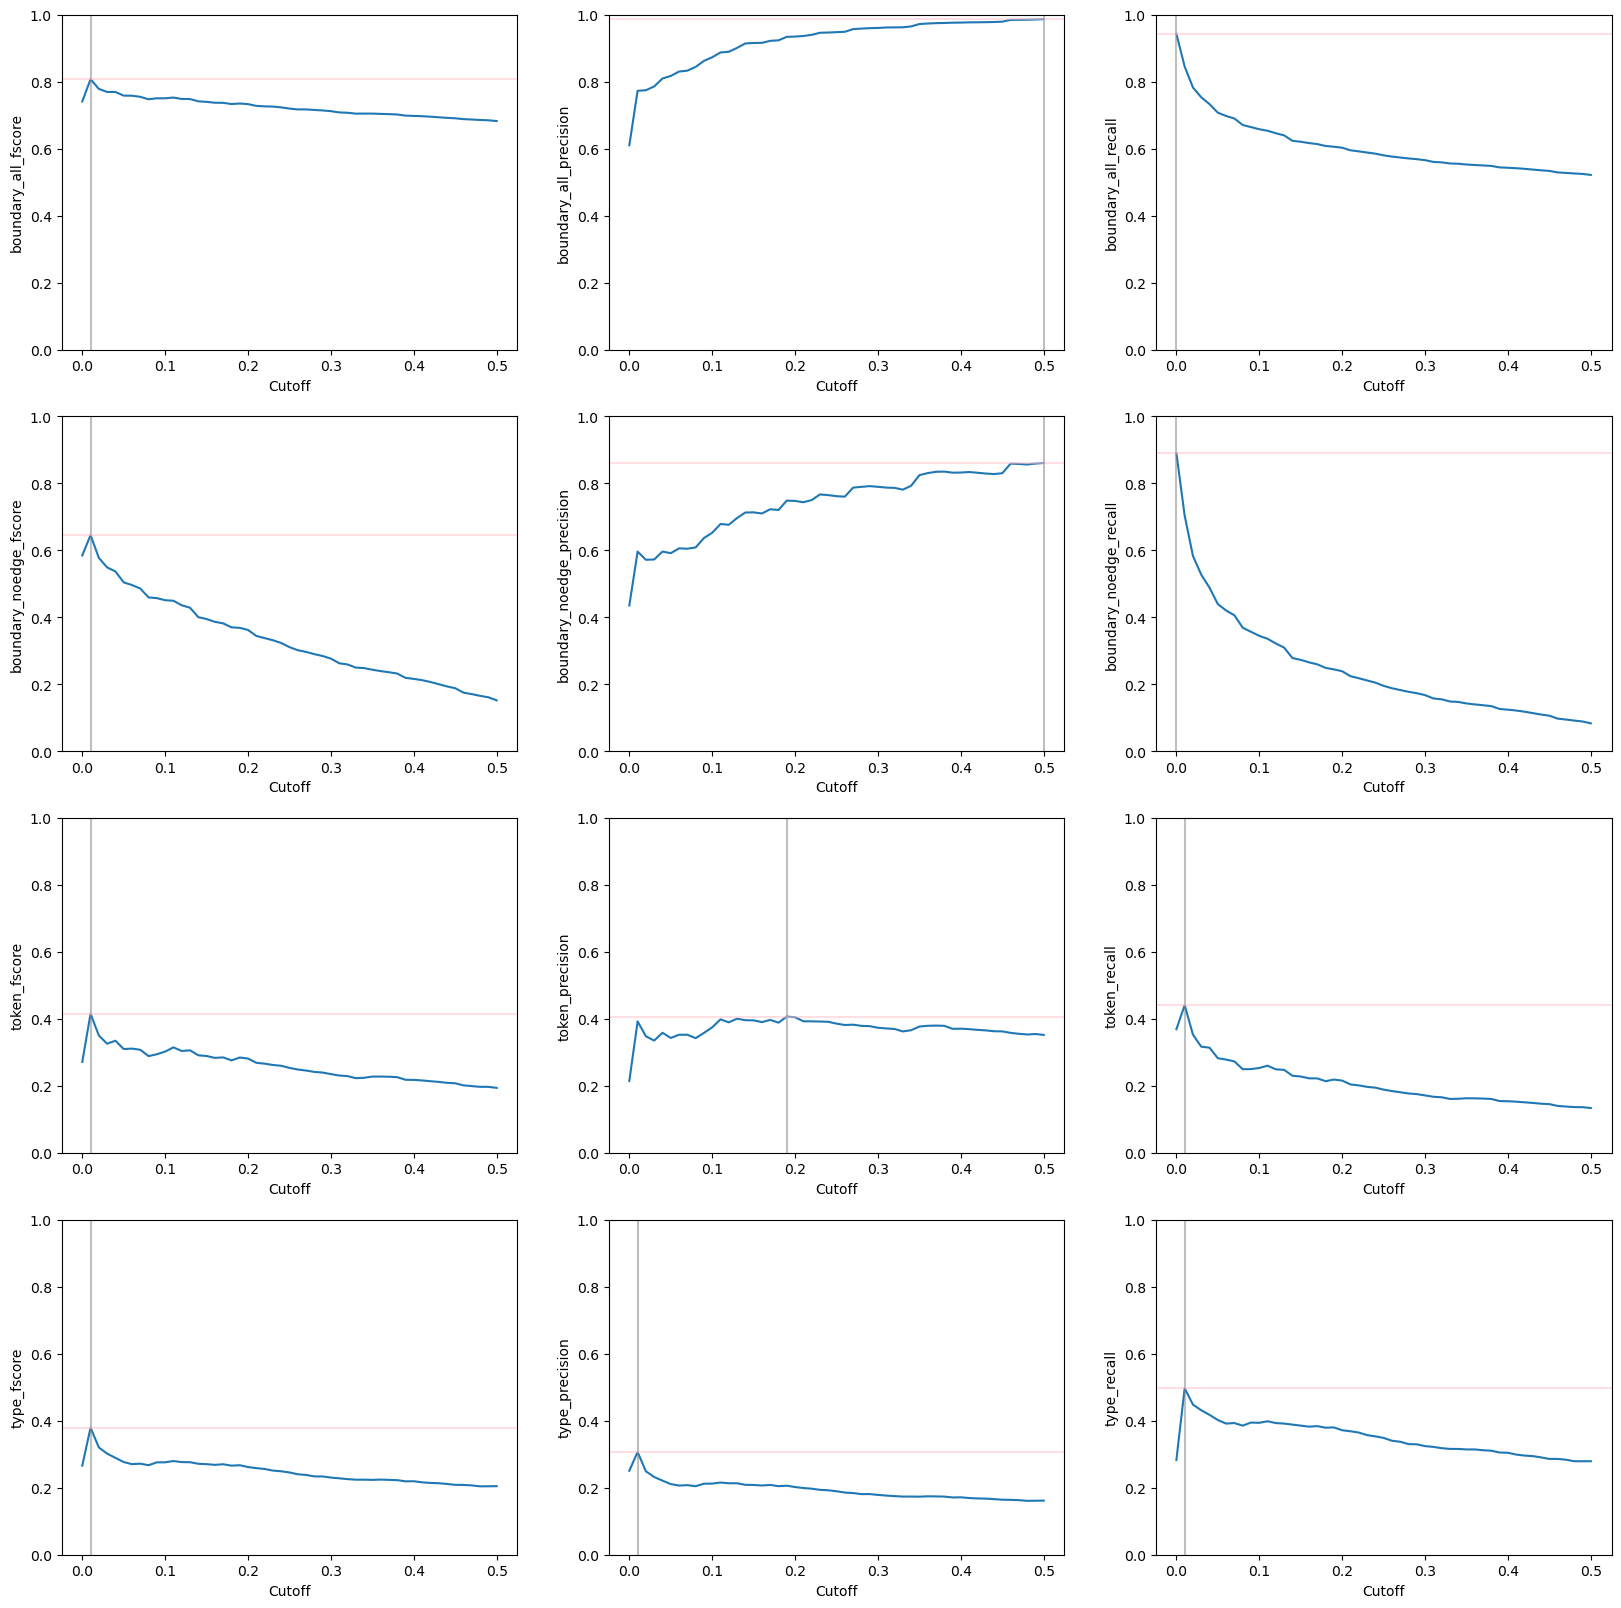

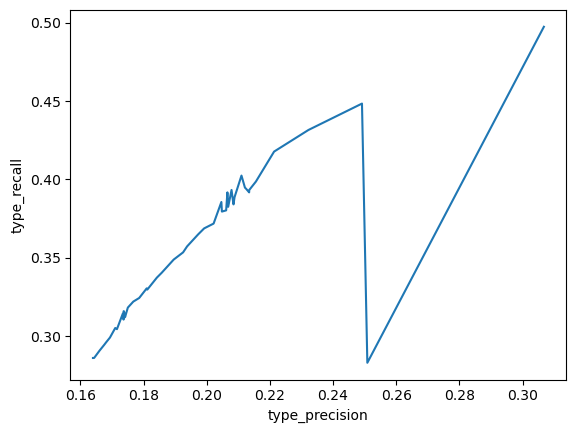

Spike type_fscore: 34.51


In [19]:
summarise_segmentation('Increase in Boundary Prediction', cutoffs=np.linspace(0,0.5,51))

Best cutoff: 6.3
Best type_fscore at cutoff 6.3: 14.81


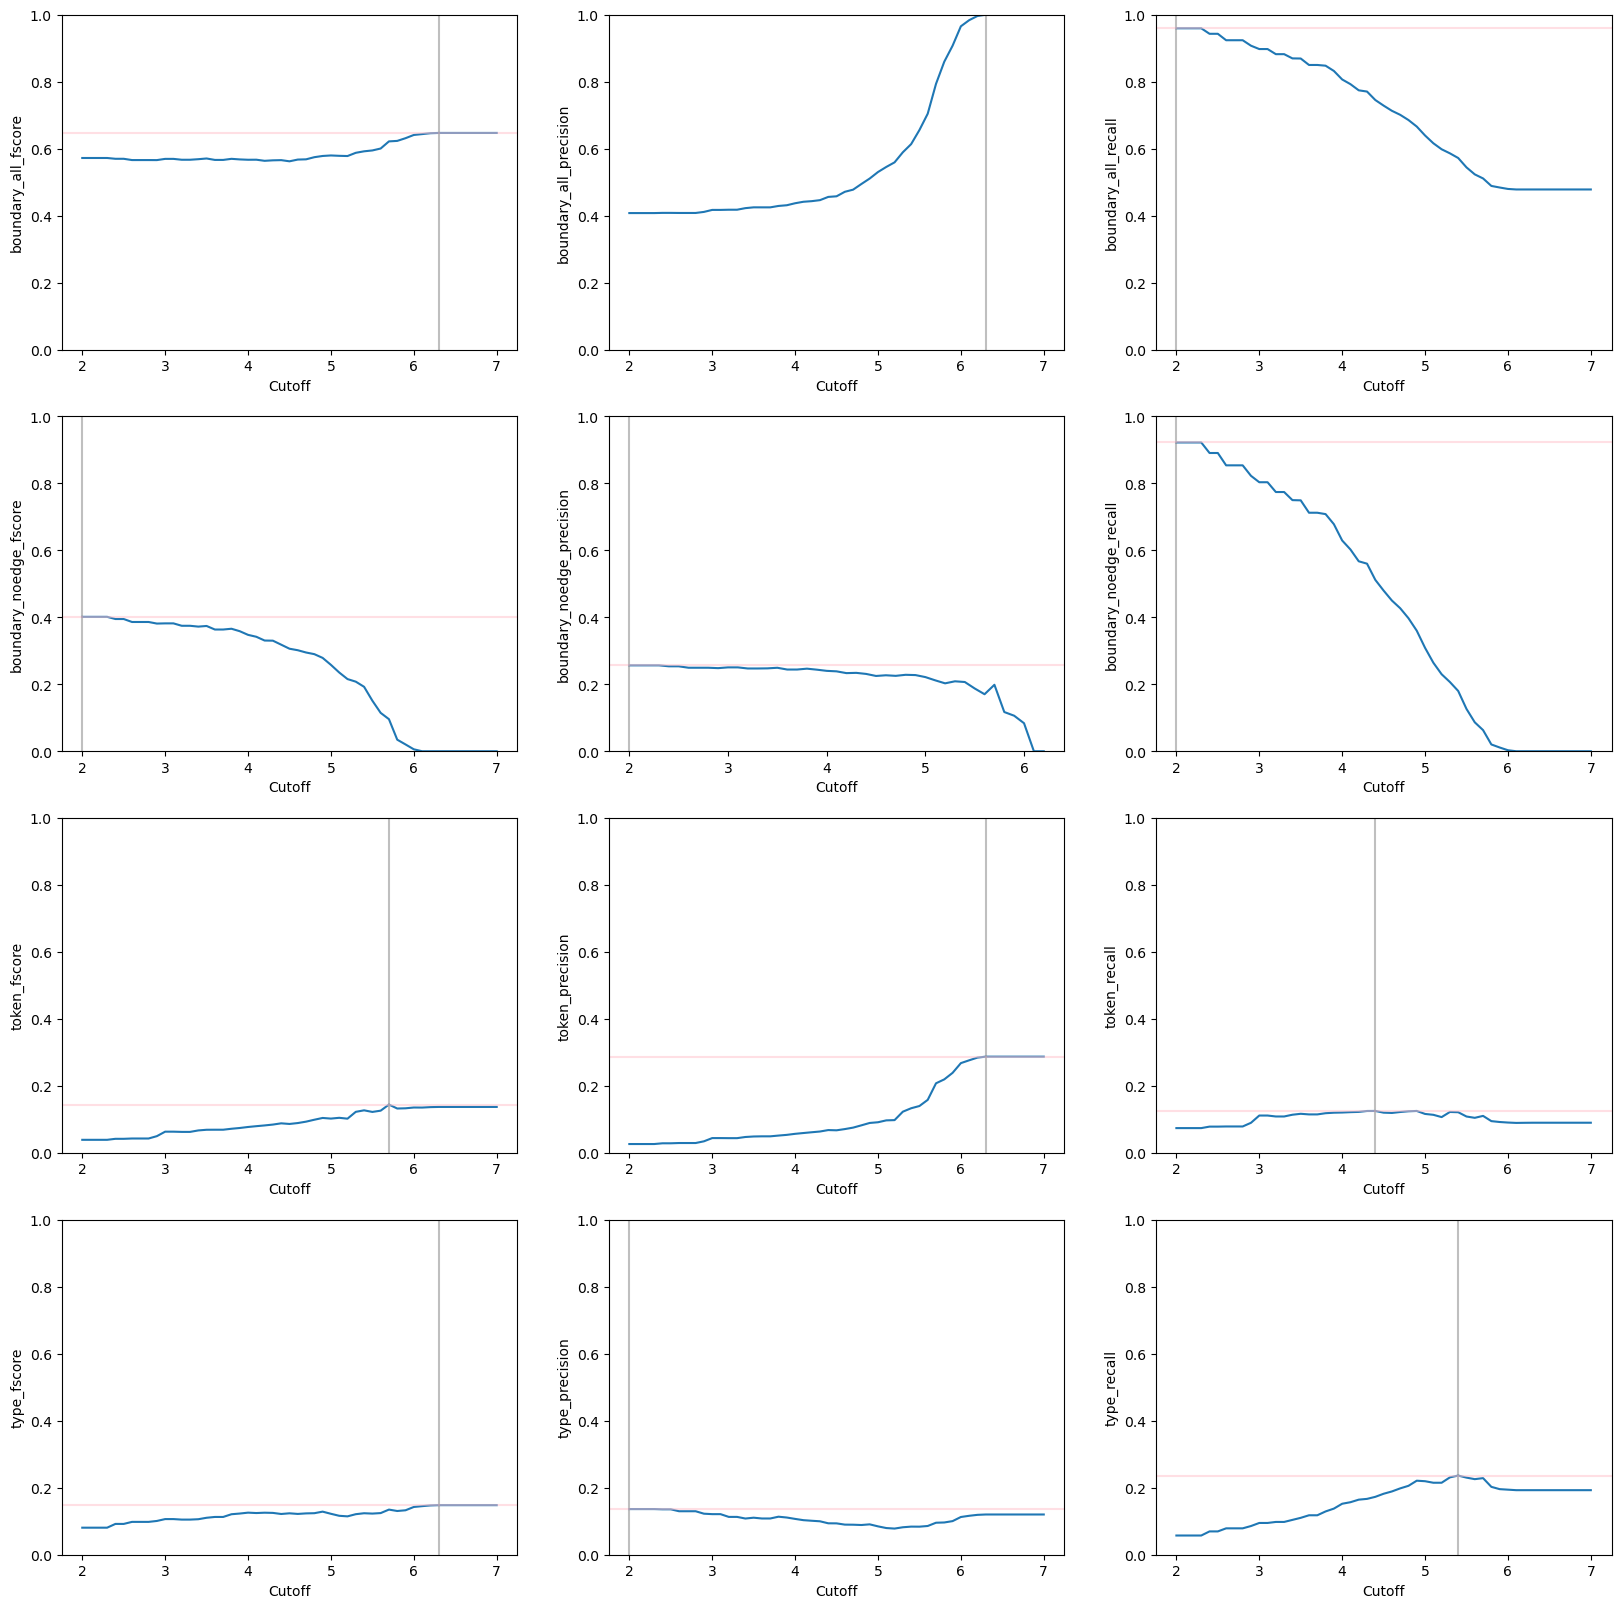

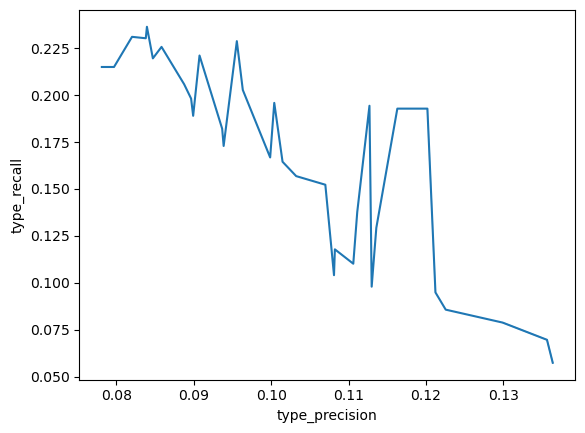

Spike type_fscore: 10.72


In [20]:
summarise_segmentation('Rank', cutoffs=np.linspace(2,7,51))